# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

X1           X2           X3           X4           X5  \
count  7845.000000  7845.000000  7845.000000  7845.000000  7845.000000   
mean      0.333764     0.200042     0.251736     0.365734     0.160780   
std       1.025813     1.136427     1.101461     0.988616     1.157123   
min      -0.784415    -0.452501    -0.591631    -0.859553    -0.377866   
25%      -0.145333    -0.408265    -0.276061    -0.859553    -0.377866   
50%       0.111790    -0.271133    -0.005571     0.550163    -0.377866   
75%       0.508993     0.219887     0.400163     1.027382     0.387549   
max      31.508443     5.085849    29.477769     9.591164    23.617122   

                X6        CLASS  
count  7845.000000  7845.000000  
mean      0.402400     0.032250  
std       0.939678     0.176674  
min      -0.945723     0.000000  
25%      -0.945723     0.000000  
50%       0.845975     0.000000  
75%       1.132403     0.000000  
max       1.949027     1.000000

### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def centroid_undersampling(data):
    '''Faz o undersampling pegando as amostras do centro do cluster
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    centrounder = ClusterCentroids(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = centrounder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = centrounder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = centroid_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

In [31]:
learnRate = 0.01
graficoName = "kmedias, lr=0.01, rede="

## RNA 1 (10)

In [34]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4123 - acc: 0.5119 - val_loss: 0.7266 - val_acc: 0.5238
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4064 - acc: 0.5198 - val_loss: 0.7165 - val_acc: 0.5238
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.4002 - acc: 0.5198 - val_loss: 0.7060 - val_acc: 0.5238
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3932 - acc: 0.5198 - val_loss: 0.6949 - val_acc: 0.5238
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.3854 - acc: 0.5278 - val_loss: 0.6837 - val_acc: 0.5317
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.3770 - acc: 0.5278 - val_loss: 0.6722 - val_acc: 0.5397
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.3678 - acc: 0.5278 - val_loss: 0.6612 - val_acc: 0.5397
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.1113 - acc: 0.8532 - val_loss: 0.2652 - val_acc: 0.8333
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8532 - val_loss: 0.2645 - val_acc: 0.8333
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8532 - val_loss: 0.2637 - val_acc: 0.8333
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8532 - val_loss: 0.2631 - val_acc: 0.8333
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.1109 - acc: 0.8532 - val_loss: 0.2624 - val_acc: 0.8333
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.1108 - acc: 0.8571 - val_loss: 0.2617 - val_acc: 0.8333
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.1107 - acc: 0.8571 - val_loss: 0.2610 - val_acc: 0.8333
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.1106 - acc: 0.8571 - val_loss: 0.2604 - v

252/252 [==============================] - 0s - loss: 0.1047 - acc: 0.8770 - val_loss: 0.2164 - val_acc: 0.8333
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2161 - val_acc: 0.8333
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2160 - val_acc: 0.8333
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2157 - val_acc: 0.8333
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.1046 - acc: 0.8770 - val_loss: 0.2155 - val_acc: 0.8333
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2153 - val_acc: 0.8333
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2151 - val_acc: 0.8333
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.1045 - acc: 0.8770 - val_loss: 0.2149 - v

252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1998 - val_acc: 0.8413
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1997 - val_acc: 0.8413
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1996 - val_acc: 0.8413
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8730 - val_loss: 0.1995 - val_acc: 0.8413
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1994 - val_acc: 0.8413
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1992 - val_acc: 0.8413
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1991 - val_acc: 0.8413
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.1023 - acc: 0.8730 - val_loss: 0.1991 - v

252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1922 - val_acc: 0.8413
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1921 - val_acc: 0.8413
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.1009 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1920 - val_acc: 0.8413
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.1008 - acc: 0.8730 - val_loss: 0.1920 - v

252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1870 - val_acc: 0.8492
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1870 - val_acc: 0.8492
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1869 - val_acc: 0.8492
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8690 - val_loss: 0.1868 - val_acc: 0.8492
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0997 - acc: 0.8730 - val_loss: 0.1867 - v

252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1822 - val_acc: 0.8492
Epoch 757/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1822 - val_acc: 0.8492
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1821 - val_acc: 0.8492
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1821 - val_acc: 0.8492
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1820 - val_acc: 0.8492
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8651 - val_loss: 0.1819 - v

252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 883/100000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1776 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1775 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1775 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1774 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1774 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0975 - acc: 0.8730 - val_loss: 0.1773 - v

252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1725 - val_acc: 0.8730
Epoch 1009/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1724 - val_acc: 0.8730
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1723 - val_acc: 0.8730
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0963 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1134/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1687 - val_acc: 0.8730
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1686 - val_acc: 0.8730
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8810 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1651 - val_acc: 0.8889
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1650 - val_acc: 0.8889
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1649 - val_acc: 0.8889
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8849 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8849 - val_loss: 0.1616 - val_acc: 0.8889
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1616 - val_acc: 0.8889
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.8810 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1615 - val_acc: 0.8889
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8810 - val_loss: 0.1614 - val_acc: 0.8889
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1578 - val_acc: 0.8889
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8810 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8810 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1577 - val_acc: 0.8889
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8889 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8889 - val_loss: 0.1541 - val_acc: 0.8810
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1513 - val_acc: 0.8810
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1512 - val_acc: 0.8810
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1887/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1489 - val_acc: 0.8810
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1891/100000
252/252 [==============================] - ETA: 0s - loss: 0.1206 - acc: 0.875 - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8929 - val_loss: 0.1488 - val_acc: 0.8810
Epoch 1893/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1468 - val_acc: 0.8810
Epoch 2012/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2013/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1466 - val_acc: 0.8810
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1467 - val_acc: 0.8810
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1459 - val_acc: 0.8810
Epoch 2138/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1459 - val_acc: 0.8810
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1458 - val_acc: 0.8810
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2263/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2264/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1445 - val_acc: 0.8810
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8889 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2388/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1431 - val_acc: 0.8810
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1430 - val_acc: 0.8810
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0884 - acc: 0.8929 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1418 - val_acc: 0.8810
Epoch 2520/100000
252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2640/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1407 - val_acc: 0.8810
Epoch 2641/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1406 - val_acc: 0.8810
Epoch 2646/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2765/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2766/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2767/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1393 - val_acc: 0.8810
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8968 - val_loss: 0.1392 - val_acc: 0.8810
Epoch 2771/100000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2891/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2892/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2894/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2895/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1380 - val_acc: 0.8810
Epoch 2896/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1379 - val_acc: 0.8810
Epoch 2897/100000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.8968 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3017/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1368 - val_acc: 0.8810
Epoch 3018/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1367 - val_acc: 0.8810
Epoch 3020/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3021/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3022/100000
252/252 [==============================] - ETA: 0s - loss: 0.1246 - acc: 0.875 - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8810
Epoch 3023/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3142/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1353 - val_acc: 0.8810
Epoch 3143/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1353 - val_acc: 0.8810
Epoch 3144/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3145/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3146/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3147/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1352 - val_acc: 0.8810
Epoch 3148/100000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1339 - val_acc: 0.8810
Epoch 3268/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3269/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3270/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3271/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1337 - val_acc: 0.8810
Epoch 3272/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1338 - val_acc: 0.8810
Epoch 3273/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1337 - val_acc: 0.8810
Epoch 3274/100000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1322 - val_acc: 0.8889
Epoch 3394/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3395/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3396/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3397/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3398/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3399/100000
252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.8889
Epoch 3400/100000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3519/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3520/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1306 - val_acc: 0.8889
Epoch 3521/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3522/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3523/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3524/100000
252/252 [==============================] - 0s - loss: 0.0852 - acc: 0.9048 - val_loss: 0.1305 - val_acc: 0.8889
Epoch 3525/100000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3646/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3647/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3648/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3649/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1291 - val_acc: 0.8889
Epoch 3650/100000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3770/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1277 - val_acc: 0.8889
Epoch 3771/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1277 - val_acc: 0.8889
Epoch 3772/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3773/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3774/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3775/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1276 - val_acc: 0.8889
Epoch 3776/100000
252/252 [==============================] - 0s - loss: 0.0844 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3894/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3895/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3896/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1263 - val_acc: 0.8889
Epoch 3897/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3898/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3899/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1262 - val_acc: 0.8889
Epoch 3900/100000
252/252 [==============================] - 0s - loss: 0.0841 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4019/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4020/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4021/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1248 - val_acc: 0.8889
Epoch 4022/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4023/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4024/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1247 - val_acc: 0.8889
Epoch 4025/100000
252/252 [==============================] - 0s - loss: 0.0838 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4144/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4145/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4146/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4147/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1232 - val_acc: 0.8889
Epoch 4148/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1233 - val_acc: 0.8889
Epoch 4149/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9008 - val_loss: 0.1232 - val_acc: 0.8889
Epoch 4150/100000
252/252 [==============================] - 0s - loss: 0.0835 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4270/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4271/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4272/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4273/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1217 - val_acc: 0.8889
Epoch 4274/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1218 - val_acc: 0.8889
Epoch 4275/100000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9008 - val_loss: 0.1217 - val_acc: 0.8889
Epoch 4276/100000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4395/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4396/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4397/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4398/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4399/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8889
Epoch 4400/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1203 - val_acc: 0.8889
Epoch 4401/100000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8889
Epoch 4521/100000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8889
Epoch 4522/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4523/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4524/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1189 - val_acc: 0.8889
Epoch 4525/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1189 - val_acc: 0.8889
Epoch 4526/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1190 - val_acc: 0.8889
Epoch 4527/100000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8889
Epoch 4646/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8889
Epoch 4647/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4648/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4649/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4650/100000
252/252 [==============================] - ETA: 0s - loss: 0.1010 - acc: 0.875 - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4651/100000
252/252 [==============================] - 0s - loss: 0.0823 - acc: 0.9008 - val_loss: 0.1177 - val_acc: 0.8889
Epoch 4652/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4771/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4772/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4773/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4774/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4775/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4776/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8889
Epoch 4777/100000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4897/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4898/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4899/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4900/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8889
Epoch 4901/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1154 - val_acc: 0.8889
Epoch 4902/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1153 - val_acc: 0.8889
Epoch 4903/100000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 5022/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5023/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5024/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5025/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5026/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1143 - val_acc: 0.8889
Epoch 5027/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1142 - val_acc: 0.8889
Epoch 5028/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 5148/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1132 - val_acc: 0.8889
Epoch 5149/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5150/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5151/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5152/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5153/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1131 - val_acc: 0.8889
Epoch 5154/100000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5273/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5274/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5275/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5276/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5277/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5278/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1117 - val_acc: 0.8889
Epoch 5279/100000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5398/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5399/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5400/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5401/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5402/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5403/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1104 - val_acc: 0.8889
Epoch 5404/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5523/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5524/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5525/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5526/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5527/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5528/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1096 - val_acc: 0.8889
Epoch 5529/100000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5649/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5650/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5651/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5652/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5653/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5654/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1088 - val_acc: 0.8889
Epoch 5655/100000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5775/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5776/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5777/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5778/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5779/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5780/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 5781/100000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5900/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5901/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5902/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5903/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5904/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5905/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 5906/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6024/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6025/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6026/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6027/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6028/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8968
Epoch 6029/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1066 - val_acc: 0.8968
Epoch 6030/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6150/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6151/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6152/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6153/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6154/100000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6155/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1060 - val_acc: 0.8968
Epoch 6156/100000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1054 - val_acc: 0.8968
Epoch 6275/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6276/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6277/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6278/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6279/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6280/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 6281/100000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6400/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6401/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6402/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6403/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6404/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6405/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1047 - val_acc: 0.8968
Epoch 6406/100000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6525/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6526/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6527/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6528/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6529/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6530/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1041 - val_acc: 0.8968
Epoch 6531/100000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6650/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6651/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6652/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6653/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6654/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6655/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8968
Epoch 6656/100000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1032 - val_acc: 0.8968
Epoch 6776/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6777/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6778/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6779/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6780/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6781/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 6782/100000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6901/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6902/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6903/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6904/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6905/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6906/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8968
Epoch 6907/100000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7026/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7027/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7028/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7029/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7030/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9087 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 7031/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1022 - val_acc: 0.8968
Epoch 7032/100000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7152/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7153/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7154/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7155/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7156/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 7157/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1018 - val_acc: 0.8968
Epoch 7158/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7277/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7278/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7279/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7280/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7281/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7282/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1015 - val_acc: 0.8968
Epoch 7283/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7403/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7404/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7405/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7406/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7407/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7408/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 7409/100000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7529/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7530/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7531/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 7532/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7533/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7534/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 7535/100000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7654/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7655/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 7656/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7657/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7658/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7659/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 7660/100000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9127 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7780/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7781/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7782/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7783/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7784/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7785/100000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9087 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 7786/100000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7906/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7907/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7908/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7909/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7910/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7911/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 7912/100000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8031/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8032/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8033/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8034/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8035/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8036/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 8037/100000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8157/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8158/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8159/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8160/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8161/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8162/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0994 - val_acc: 0.8968
Epoch 8163/100000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9127 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8283/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8284/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8285/100000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8286/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8287/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8288/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 8289/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8409/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8410/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8411/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8412/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8413/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8414/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0989 - val_acc: 0.8968
Epoch 8415/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8535/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8536/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8537/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8538/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8539/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8540/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0987 - val_acc: 0.8968
Epoch 8541/100000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8660/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8661/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8662/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8663/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8664/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8665/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0985 - val_acc: 0.8968
Epoch 8666/100000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8786/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8787/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8788/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8789/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8790/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8791/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0983 - val_acc: 0.8968
Epoch 8792/100000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8912/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8913/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8914/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8915/100000
252/252 [==============================] - ETA: 0s - loss: 0.0541 - acc: 0.968 - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8916/100000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8917/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0981 - val_acc: 0.8968
Epoch 8918/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9036/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9037/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9038/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9039/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9040/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9041/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0979 - val_acc: 0.8968
Epoch 9042/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9160/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9161/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9162/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9163/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9164/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9165/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0977 - val_acc: 0.8968
Epoch 9166/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9285/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9286/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9287/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9288/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9289/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9290/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0975 - val_acc: 0.8968
Epoch 9291/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9410/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9411/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9412/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9413/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9414/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9415/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0973 - val_acc: 0.8968
Epoch 9416/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9535/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9536/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9537/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9538/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9539/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9540/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0971 - val_acc: 0.8968
Epoch 9541/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9661/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9662/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9663/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9664/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9665/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9666/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0970 - val_acc: 0.8968
Epoch 9667/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9787/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9788/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9789/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9790/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9791/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9792/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0968 - val_acc: 0.8968
Epoch 9793/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9913/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9914/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9915/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9916/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9917/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9918/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0967 - val_acc: 0.8968
Epoch 9919/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10037/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10038/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10039/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0966 - val_acc: 0.8968
Epoch 10040/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10041/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10042/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 10043/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10161/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10162/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10163/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10164/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10165/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10166/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 10167/100000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10285/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10286/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10287/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10288/100000
252/252 [==============================] - ETA: 0s - loss: 0.0840 - acc: 0.937 - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10289/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10290/100000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9167 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 10291/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10409/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10410/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10411/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10412/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10413/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10414/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 10415/100000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10533/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10534/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10535/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10536/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10537/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10538/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 10539/100000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10657/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10658/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10659/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10660/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10661/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10662/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_loss: 0.0960 - val_acc: 0.8968
Epoch 10663/100000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10781/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10782/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10783/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10784/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10785/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 10786/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 10787/100000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10905/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10906/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10907/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10908/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10909/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10910/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0957 - val_acc: 0.8968
Epoch 10911/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11029/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11030/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11031/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11032/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11033/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11034/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11035/100000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11091/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11092/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11093/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11094/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11095/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11096/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 11097/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11215/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11216/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11217/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11218/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11219/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11220/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 11221/100000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11339/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11340/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 11341/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11342/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11343/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11344/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11345/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11463/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11464/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11465/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11466/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11467/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11468/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 11469/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11587/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11588/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11589/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11590/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11591/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11592/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 11593/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9167 - val_lo

252/252 [==============================] - ETA: 0s - loss: 0.0609 - acc: 0.937 - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11711/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11712/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11713/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11714/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11715/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11716/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9167 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 11717/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11835/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11836/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11837/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11838/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11839/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11840/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.8889
Epoch 11841/100000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11959/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11960/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11961/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11962/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11963/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11964/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 11965/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12083/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12084/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12085/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12086/100000
252/252 [==============================] - ETA: 0s - loss: 0.1018 - acc: 0.875 - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12087/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12088/100000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9167 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 12089/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12207/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12208/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12209/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12210/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12211/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12212/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12213/100000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12331/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12332/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12333/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12334/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12335/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12336/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 12337/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12455/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12456/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12457/100000
252/252 [==============================] - ETA: 0s - loss: 0.0740 - acc: 0.937 - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12458/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12459/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12460/100000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12461/100000
252/252 [==============================] - 0s

252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12579/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12580/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12581/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12582/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12583/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12584/100000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9167 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 12585/100000
252/252 [==============================] - ETA: 0s - loss: 0.1277 - acc: 0.781 - 0s

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12703/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12704/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12705/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12706/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12707/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12708/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.8889
Epoch 12709/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12827/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12828/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12829/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12830/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12831/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12832/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12833/100000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12951/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12952/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12953/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12954/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12955/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12956/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 12957/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13075/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13076/100000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13077/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13078/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13079/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13080/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13081/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13199/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13200/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13201/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13202/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13203/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13204/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8810
Epoch 13205/100000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_lo

In [35]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1696/1962 [========================>.....] - ETA: 0s[0.056663505436456693, 0.9194699286442406]


<IPython.core.display.Javascript object>


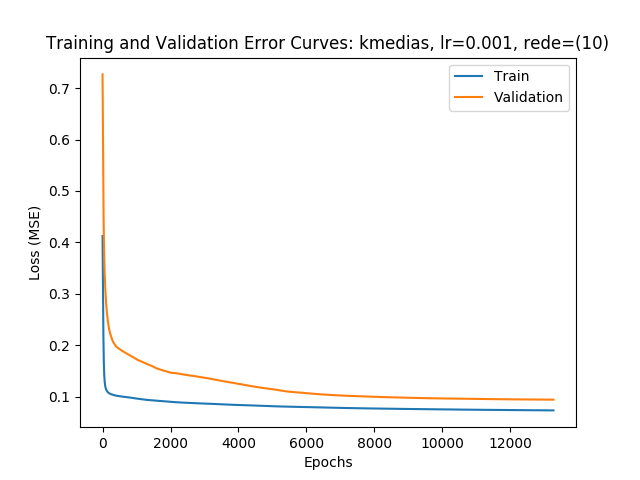

<IPython.core.display.Javascript object>


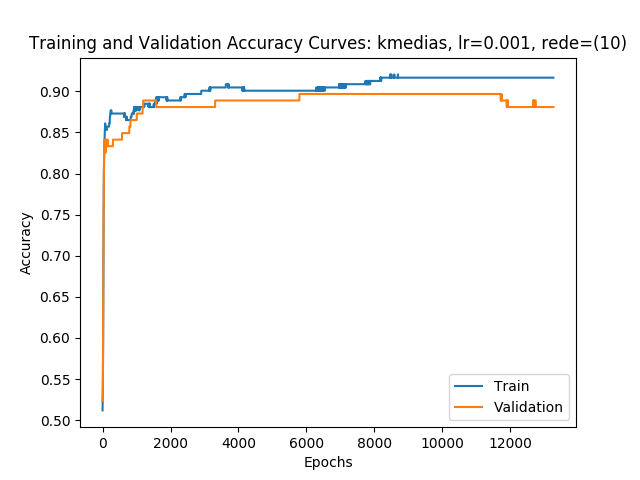

Matriz de confusão
[[1749  149]
 [   9   55]]

Train Loss:       0.0734
Validation Loss:  0.0943
Accuracy:         0.9195
MSE:              0.0805
AUROC:            0.9411


In [36]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [28]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.3080 - acc: 0.5833 - val_loss: 0.3409 - val_acc: 0.5873
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.2503 - acc: 0.6587 - val_loss: 0.3152 - val_acc: 0.6190
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.2156 - acc: 0.6825 - val_loss: 0.2996 - val_acc: 0.6587
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.1950 - acc: 0.6944 - val_loss: 0.2887 - val_acc: 0.6905
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.1803 - acc: 0.7183 - val_loss: 0.2811 - val_acc: 0.7143
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.1698 - acc: 0.7540 - val_loss: 0.2710 - val_acc: 0.7460
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.1619 - acc: 0.7778 - val_loss: 0.2617 - val_acc: 0.7937
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0880 - acc: 0.8929 - val_loss: 0.1552 - val_acc: 0.8413
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8929 - val_loss: 0.1553 - val_acc: 0.8413
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0878 - acc: 0.8929 - val_loss: 0.1548 - val_acc: 0.8413
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8929 - val_loss: 0.1545 - val_acc: 0.8413
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8929 - val_loss: 0.1543 - val_acc: 0.8413
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8929 - val_loss: 0.1532 - val_acc: 0.8413
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.8929 - val_loss: 0.1527 - val_acc: 0.8413
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.8929 - val_loss: 0.1526 - v

252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8492
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1358 - val_acc: 0.8492
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.9008 - val_loss: 0.1355 - val_acc: 0.8492
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1361 - val_acc: 0.8492
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0808 - acc: 0.8968 - val_loss: 0.1363 - val_acc: 0.8492
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1363 - val_acc: 0.8492
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.9008 - val_loss: 0.1366 - val_acc: 0.8492
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.9008 - val_loss: 0.1361 - v

252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9127 - val_loss: 0.1324 - val_acc: 0.8492
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9127 - val_loss: 0.1318 - val_acc: 0.8492
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1313 - val_acc: 0.8492
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1317 - val_acc: 0.8492
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0780 - acc: 0.9087 - val_loss: 0.1315 - val_acc: 0.8492
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9087 - val_loss: 0.1322 - val_acc: 0.8492
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9008 - val_loss: 0.1321 - v

252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1298 - val_acc: 0.8492
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9127 - val_loss: 0.1296 - val_acc: 0.8492
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1297 - val_acc: 0.8492
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1298 - val_acc: 0.8492
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.1299 - val_acc: 0.8571
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1299 - val_acc: 0.8492
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1298 - val_acc: 0.8413
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9087 - val_loss: 0.1297 - v

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9087 - val_loss: 0.1279 - val_acc: 0.8492
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9087 - val_loss: 0.1280 - val_acc: 0.8492
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9087 - val_loss: 0.1274 - val_acc: 0.8492
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.1281 - val_acc: 0.8492
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9087 - val_loss: 0.1278 - val_acc: 0.8492
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.1280 - val_acc: 0.8492
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9087 - val_loss: 0.1276 - val_acc: 0.8492
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.1278 - v

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9087 - val_loss: 0.1270 - val_acc: 0.8492
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9087 - val_loss: 0.1272 - val_acc: 0.8492
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9087 - val_loss: 0.1270 - val_acc: 0.8492
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9087 - val_loss: 0.1274 - val_acc: 0.8492
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9087 - val_loss: 0.1276 - val_acc: 0.8492
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9127 - val_loss: 0.1280 - val_acc: 0.8492
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.1274 - val_acc: 0.8492
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9087 - val_loss: 0.1272 - v

252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1260 - val_acc: 0.8492
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1262 - val_acc: 0.8492
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1258 - val_acc: 0.8492
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1261 - val_acc: 0.8492
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1258 - val_acc: 0.8492
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1253 - val_acc: 0.8492
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1264 - val_acc: 0.8492
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1265 - v

252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9087 - val_loss: 0.1246 - val_acc: 0.8492
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9127 - val_loss: 0.1246 - val_acc: 0.8492
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1242 - val_acc: 0.8492
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1241 - val_acc: 0.8492
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1243 - val_acc: 0.8492
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9087 - val_loss: 0.1246 - val_acc: 0.8492
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9127 - val_loss: 0.1238 - val_acc: 0.8492
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.0708 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9087 - val_loss: 0.1213 - val_acc: 0.8571
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1215 - val_acc: 0.8571
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1219 - val_acc: 0.8571
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9087 - val_loss: 0.1217 - val_acc: 0.8571
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9087 - val_loss: 0.1211 - val_acc: 0.8571
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1218 - val_acc: 0.8571
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9087 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 1261/100000
252/252 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.937 - 0s - loss: 0.0684 - acc: 0.9087 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9087 - val_loss: 0.1190 - val_acc: 0.8571
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9087 - val_loss: 0.1185 - val_acc: 0.8571
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9087 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9087 - val_loss: 0.1180 - val_acc: 0.8571
Epoch 1266/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1162 - val_acc: 0.8571
Epoch 1385/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1165 - val_acc: 0.8571
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1165 - val_acc: 0.8571
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1165 - val_acc: 0.8571
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9087 - val_loss: 0.1171 - val_acc: 0.8571
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1172 - val_acc: 0.8571
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9087 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 1510/100000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9127 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 1511/100000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 1512/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.1154 - val_acc: 0.8571
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9087 - val_loss: 0.1153 - val_acc: 0.8571
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9087 - val_loss: 0.1149 - val_acc: 0.8571
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9087 - val_loss: 0.1146 - val_acc: 0.8651
Epoch 1636/100000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9127 - val_loss: 0.1142 - val_acc: 0.8571
Epoch 1637/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9127 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9127 - val_loss: 0.1148 - val_acc: 0.8651
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9127 - val_loss: 0.1144 - val_acc: 0.8651
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9127 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9087 - val_loss: 0.1142 - val_acc: 0.8571
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 1760/100000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9127 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1761/100000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1762/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8651
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9127 - val_loss: 0.1133 - val_acc: 0.8651
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9127 - val_loss: 0.1129 - val_acc: 0.8571
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9127 - val_loss: 0.1129 - val_acc: 0.8571
Epoch 1886/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.1126 - val_acc: 0.8571
Epoch 1887/100000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9127 - val_loss: 0.1131 - val_acc: 0.8571
Epoch 1888/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9127 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.1133 - val_acc: 0.8571
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9127 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.1124 - val_acc: 0.8571
Epoch 2012/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8571
Epoch 2013/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9127 - val_loss: 0.1120 - val_acc: 0.8571
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.1126 - val_acc: 0.8571
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.1124 - val_acc: 0.8571
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9127 - val_loss: 0.1121 - val_acc: 0.8571
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9127 - val_loss: 0.1122 - val_acc: 0.8571
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9127 - val_loss: 0.1115 - val_acc: 0.8571
Epoch 2137/100000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9127 - val_loss: 0.1115 - val_acc: 0.8571
Epoch 2138/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8571
Epoch 2139/100000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9127 - val_loss: 0.1116 - val_acc: 0.8571
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8571
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9127 - val_loss: 0.1122 - val_acc: 0.8571
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8571
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9127 - val_loss: 0.1114 - val_acc: 0.8571
Epoch 2263/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9167 - val_loss: 0.1117 - val_acc: 0.8651
Epoch 2264/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9127 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9127 - val_loss: 0.1115 - val_acc: 0.8571
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9127 - val_loss: 0.1115 - val_acc: 0.8571
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8571
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9127 - val_loss: 0.1116 - val_acc: 0.8571
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9127 - val_loss: 0.1108 - val_acc: 0.8571
Epoch 2388/100000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9127 - val_loss: 0.1113 - val_acc: 0.8571
Epoch 2389/100000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9127 - val_loss: 0.1114 - val_acc: 0.8571
Epoch 2390/100000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9127 - val_loss: 0.1116 - val_acc: 0.8571
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9167 - val_loss: 0.1111 - val_acc: 0.8571
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9127 - val_loss: 0.1111 - val_acc: 0.8571
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9127 - val_loss: 0.1113 - val_acc: 0.8571
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9127 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9127 - val_loss: 0.1112 - val_acc: 0.8571
Epoch 2513/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9206 - val_loss: 0.1105 - val_acc: 0.8571
Epoch 2514/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9206 - val_loss: 0.1112 - val_acc: 0.8571
Epoch 2515/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8571
Epoch 2516/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9167 - val_loss: 0.1107 - val_acc: 0.8571
Epoch 2517/100000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9206 - val_loss: 0.1108 - val_acc: 0.8571
Epoch 2518/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9206 - val_loss: 0.1103 - val_acc: 0.8571
Epoch 2519/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9167 - val_loss: 0.1109 - val_acc: 0.8571
Epoch 2639/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9167 - val_loss: 0.1110 - val_acc: 0.8571
Epoch 2640/100000
252/252 [==============================] - 0s - loss: 0.0614 - acc: 0.9167 - val_loss: 0.1112 - val_acc: 0.8571
Epoch 2641/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9206 - val_loss: 0.1100 - val_acc: 0.8571
Epoch 2642/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9167 - val_loss: 0.1111 - val_acc: 0.8651
Epoch 2643/100000
252/252 [==============================] - 0s - loss: 0.0613 - acc: 0.9206 - val_loss: 0.1108 - val_acc: 0.8571
Epoch 2644/100000
252/252 [==============================] - 0s - loss: 0.0614 - acc: 0.9206 - val_loss: 0.1108 - val_acc: 0.8571
Epoch 2645/100000
252/252 [==============================] - 0s - loss: 0.0614 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9206 - val_loss: 0.1104 - val_acc: 0.8571
Epoch 2764/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9206 - val_loss: 0.1104 - val_acc: 0.8571
Epoch 2765/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9206 - val_loss: 0.1105 - val_acc: 0.8571
Epoch 2766/100000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9167 - val_loss: 0.1106 - val_acc: 0.8571
Epoch 2767/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9206 - val_loss: 0.1100 - val_acc: 0.8571
Epoch 2768/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8571
Epoch 2769/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9206 - val_loss: 0.1103 - val_acc: 0.8571
Epoch 2770/100000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9206 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9286 - val_loss: 0.1107 - val_acc: 0.8571
Epoch 2889/100000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9246 - val_loss: 0.1107 - val_acc: 0.8571
Epoch 2890/100000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8571
Epoch 2891/100000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9246 - val_loss: 0.1101 - val_acc: 0.8571
Epoch 2892/100000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9286 - val_loss: 0.1107 - val_acc: 0.8571
Epoch 2893/100000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 2894/100000
252/252 [==============================] - ETA: 0s - loss: 0.0466 - acc: 0.906 - 0s - loss: 0.0603 - acc: 0.9246 - val_loss: 0.1106 - val_acc: 0.8571
Epoch 2895/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9246 - val_loss: 0.1101 - val_acc: 0.8651
Epoch 3013/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9206 - val_loss: 0.1093 - val_acc: 0.8651
Epoch 3014/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9286 - val_loss: 0.1095 - val_acc: 0.8651
Epoch 3015/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 3016/100000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9246 - val_loss: 0.1099 - val_acc: 0.8651
Epoch 3017/100000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9246 - val_loss: 0.1100 - val_acc: 0.8651
Epoch 3018/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9246 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 3019/100000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9246 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9246 - val_loss: 0.1096 - val_acc: 0.8651
Epoch 3137/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9246 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 3138/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9246 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 3139/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9286 - val_loss: 0.1101 - val_acc: 0.8571
Epoch 3140/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9246 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 3141/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9246 - val_loss: 0.1095 - val_acc: 0.8651
Epoch 3142/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9246 - val_loss: 0.1099 - val_acc: 0.8651
Epoch 3143/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9246 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9286 - val_loss: 0.1096 - val_acc: 0.8571
Epoch 3262/100000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 3263/100000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9246 - val_loss: 0.1098 - val_acc: 0.8571
Epoch 3264/100000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3265/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9286 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3266/100000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9246 - val_loss: 0.1098 - val_acc: 0.8571
Epoch 3267/100000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3268/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9325 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9325 - val_loss: 0.1101 - val_acc: 0.8571
Epoch 3388/100000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8571
Epoch 3389/100000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9286 - val_loss: 0.1089 - val_acc: 0.8571
Epoch 3390/100000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9286 - val_loss: 0.1090 - val_acc: 0.8571
Epoch 3391/100000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8571
Epoch 3392/100000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9286 - val_loss: 0.1094 - val_acc: 0.8571
Epoch 3393/100000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9286 - val_loss: 0.1093 - val_acc: 0.8571
Epoch 3394/100000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9286 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9325 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 3513/100000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9325 - val_loss: 0.1099 - val_acc: 0.8571
Epoch 3514/100000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9286 - val_loss: 0.1093 - val_acc: 0.8571
Epoch 3515/100000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9325 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3516/100000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9325 - val_loss: 0.1091 - val_acc: 0.8571
Epoch 3517/100000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9325 - val_loss: 0.1087 - val_acc: 0.8571
Epoch 3518/100000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9325 - val_loss: 0.1094 - val_acc: 0.8571
Epoch 3519/100000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9286 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9325 - val_loss: 0.1092 - val_acc: 0.8571
Epoch 3639/100000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9325 - val_loss: 0.1093 - val_acc: 0.8571
Epoch 3640/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9325 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3641/100000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9325 - val_loss: 0.1098 - val_acc: 0.8571
Epoch 3642/100000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9325 - val_loss: 0.1095 - val_acc: 0.8571
Epoch 3643/100000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9325 - val_loss: 0.1094 - val_acc: 0.8571
Epoch 3644/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9325 - val_loss: 0.1091 - val_acc: 0.8571
Epoch 3645/100000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9325 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9365 - val_loss: 0.1089 - val_acc: 0.8571
Epoch 3765/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9365 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 3766/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9325 - val_loss: 0.1084 - val_acc: 0.8651
Epoch 3767/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9365 - val_loss: 0.1087 - val_acc: 0.8730
Epoch 3768/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9325 - val_loss: 0.1096 - val_acc: 0.8571
Epoch 3769/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9325 - val_loss: 0.1094 - val_acc: 0.8571
Epoch 3770/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9325 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 3771/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9325 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9365 - val_loss: 0.1088 - val_acc: 0.8571
Epoch 3890/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9365 - val_loss: 0.1086 - val_acc: 0.8571
Epoch 3891/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9365 - val_loss: 0.1089 - val_acc: 0.8571
Epoch 3892/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9365 - val_loss: 0.1089 - val_acc: 0.8730
Epoch 3893/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9365 - val_loss: 0.1088 - val_acc: 0.8651
Epoch 3894/100000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9365 - val_loss: 0.1090 - val_acc: 0.8571
Epoch 3895/100000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9405 - val_loss: 0.1087 - val_acc: 0.8730
Epoch 3896/100000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9365 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9405 - val_loss: 0.1092 - val_acc: 0.8571
Epoch 4016/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9365 - val_loss: 0.1089 - val_acc: 0.8571
Epoch 4017/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9405 - val_loss: 0.1086 - val_acc: 0.8730
Epoch 4018/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9365 - val_loss: 0.1086 - val_acc: 0.8730
Epoch 4019/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9365 - val_loss: 0.1090 - val_acc: 0.8651
Epoch 4020/100000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9365 - val_loss: 0.1091 - val_acc: 0.8651
Epoch 4021/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9405 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 4022/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9405 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9405 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 4142/100000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9405 - val_loss: 0.1084 - val_acc: 0.8730
Epoch 4143/100000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9405 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 4144/100000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9405 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 4145/100000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9405 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 4146/100000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9405 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 4147/100000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9405 - val_loss: 0.1088 - val_acc: 0.8730
Epoch 4148/100000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9405 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 4266/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 4267/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9405 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 4268/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9405 - val_loss: 0.1087 - val_acc: 0.8810
Epoch 4269/100000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9405 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 4270/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 4271/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 4272/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 4391/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9444 - val_loss: 0.1088 - val_acc: 0.8810
Epoch 4392/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9405 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 4393/100000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9405 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 4394/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9405 - val_loss: 0.1084 - val_acc: 0.8810
Epoch 4395/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9405 - val_loss: 0.1084 - val_acc: 0.8810
Epoch 4396/100000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9444 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 4397/100000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9405 - val_loss: 0.1

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.07418731588843705, 0.9194699286442406]


<IPython.core.display.Javascript object>


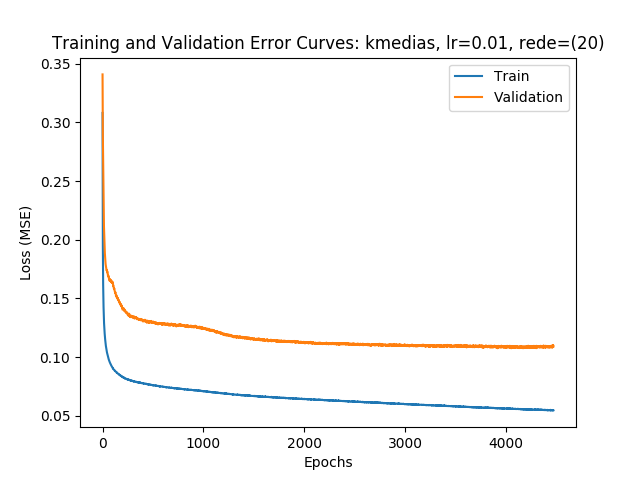

<IPython.core.display.Javascript object>


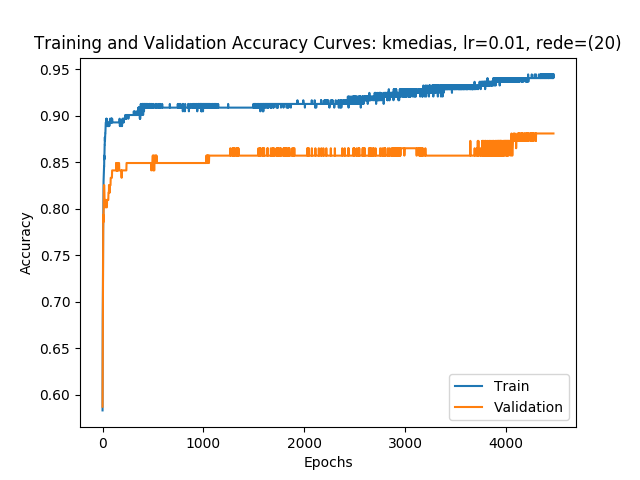

Matriz de confusão
[[1754  144]
 [   7   57]]

Train Loss:       0.0555
Validation Loss:  0.1075
Accuracy:         0.9230
MSE:              0.0770
AUROC:            0.9460


In [29]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [34]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4596 - acc: 0.4524 - val_loss: 0.4318 - val_acc: 0.4683
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4104 - acc: 0.4524 - val_loss: 0.3658 - val_acc: 0.4841
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3500 - acc: 0.4563 - val_loss: 0.3190 - val_acc: 0.4762
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3065 - acc: 0.4722 - val_loss: 0.2848 - val_acc: 0.4841
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.2736 - acc: 0.4802 - val_loss: 0.2587 - val_acc: 0.4762
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.2485 - acc: 0.4960 - val_loss: 0.2386 - val_acc: 0.5159
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.2283 - acc: 0.5119 - val_loss: 0.2223 - val_acc: 0.5238
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0928 - acc: 0.8849 - val_loss: 0.1356 - val_acc: 0.8492
Epoch 65/100000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8849 - val_loss: 0.1353 - val_acc: 0.8492
Epoch 66/100000
252/252 [==============================] - 0s - loss: 0.0922 - acc: 0.8849 - val_loss: 0.1350 - val_acc: 0.8492
Epoch 67/100000
252/252 [==============================] - 0s - loss: 0.0921 - acc: 0.8849 - val_loss: 0.1346 - val_acc: 0.8492
Epoch 68/100000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.8849 - val_loss: 0.1342 - val_acc: 0.8492
Epoch 69/100000
252/252 [==============================] - 0s - loss: 0.0915 - acc: 0.8849 - val_loss: 0.1339 - val_acc: 0.8492
Epoch 70/100000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8849 - val_loss: 0.1336 - val_acc: 0.8492
Epoch 71/100000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1332 - val_acc:

252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9008 - val_loss: 0.1217 - val_acc: 0.8492
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9048 - val_loss: 0.1216 - val_acc: 0.8492
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9008 - val_loss: 0.1215 - val_acc: 0.8492
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0814 - acc: 0.9048 - val_loss: 0.1213 - val_acc: 0.8492
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.9008 - val_loss: 0.1211 - val_acc: 0.8492
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0811 - acc: 0.9048 - val_loss: 0.1210 - val_acc: 0.8492
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8492
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.9048 - val_loss: 0.1207 - v

252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 191/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 192/100000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 193/100000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 194/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.1157 - val_acc: 0.8651
Epoch 195/100000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8651
Epoch 196/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9048 - val_loss: 0.1154 - val_acc: 0.8651
Epoch 197/100000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.1154 - v

252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1128 - val_acc: 0.8651
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9087 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1127 - val_acc: 0.8651
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1125 - val_acc: 0.8651
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9127 - val_loss: 0.1125 - val_acc: 0.8651
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1124 - v

252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9127 - val_loss: 0.1112 - val_acc: 0.8730
Epoch 317/100000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1113 - val_acc: 0.8730
Epoch 318/100000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1112 - val_acc: 0.8730
Epoch 319/100000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1112 - val_acc: 0.8730
Epoch 320/100000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1112 - val_acc: 0.8730
Epoch 321/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.1112 - val_acc: 0.8730
Epoch 322/100000
252/252 [==============================] - 0s - loss: 0.0705 - acc: 0.9167 - val_loss: 0.1111 - val_acc: 0.8730
Epoch 323/100000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9127 - val_loss: 0.1110 - v

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8810
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9127 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9127 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9167 - val_loss: 0.1105 - v

252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9127 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9127 - val_loss: 0.1094 - v

252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9127 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 506/100000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9127 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 507/100000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9127 - val_loss: 0.1079 - val_acc: 0.8810
Epoch 508/100000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9127 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 509/100000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9127 - val_loss: 0.1079 - val_acc: 0.8810
Epoch 510/100000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9127 - val_loss: 0.1079 - val_acc: 0.8810
Epoch 511/100000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9127 - val_loss: 0.1077 - val_acc: 0.8810
Epoch 512/100000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9167 - val_loss: 0.1079 - v

252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1069 - val_acc: 0.8810
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9167 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9167 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9167 - val_loss: 0.1067 - val_acc: 0.8810
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9167 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1067 - val_acc: 0.8810
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9167 - val_loss: 0.1066 - v

252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9167 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1048 - val_acc: 0.8810
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9167 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1050 - val_acc: 0.8810
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9167 - val_loss: 0.1049 - val_acc: 0.8810
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9167 - val_loss: 0.1049 - v

252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9167 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 695/100000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9167 - val_loss: 0.1033 - val_acc: 0.8810
Epoch 696/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9167 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 697/100000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9167 - val_loss: 0.1033 - val_acc: 0.8810
Epoch 698/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9167 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 699/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9167 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 700/100000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9167 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 701/100000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9167 - val_loss: 0.1031 - v

252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1021 - val_acc: 0.8810
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1019 - val_acc: 0.8810
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9167 - val_loss: 0.1019 - val_acc: 0.8810
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9167 - val_loss: 0.1020 - val_acc: 0.8810
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9206 - val_loss: 0.1020 - v

252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9206 - val_loss: 0.1007 - val_acc: 0.8889
Epoch 821/100000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8889
Epoch 822/100000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8810
Epoch 823/100000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9206 - val_loss: 0.1007 - val_acc: 0.8810
Epoch 824/100000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8810
Epoch 825/100000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9206 - val_loss: 0.1009 - val_acc: 0.8810
Epoch 826/100000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8810
Epoch 827/100000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.1008 - v

252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9246 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9246 - val_loss: 0.0996 - val_acc: 0.9048
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9206 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9246 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.9048
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8968
Epoch 890/100000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9206 - val_loss: 0.0996 - v

252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9206 - val_loss: 0.0987 - val_acc: 0.9048
Epoch 947/100000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9206 - val_loss: 0.0986 - val_acc: 0.9048
Epoch 948/100000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9206 - val_loss: 0.0986 - val_acc: 0.9048
Epoch 949/100000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9206 - val_loss: 0.0985 - val_acc: 0.9048
Epoch 950/100000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0985 - val_acc: 0.9048
Epoch 951/100000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9246 - val_loss: 0.0985 - val_acc: 0.9048
Epoch 952/100000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9246 - val_loss: 0.0984 - val_acc: 0.9048
Epoch 953/100000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0984 - v

252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9286 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9206 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9286 - val_loss: 0.0973 - val_acc: 0.9048
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9206 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9206 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9246 - val_loss: 0.0975 - val_acc: 0.9048
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9246 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1016/100000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9246 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9246 - val_loss: 0.0963 - val_acc: 0.9048
Epoch 1073/100000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9286 - val_loss: 0.0962 - val_acc: 0.9048
Epoch 1074/100000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9246 - val_loss: 0.0962 - val_acc: 0.9048
Epoch 1075/100000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9246 - val_loss: 0.0963 - val_acc: 0.9048
Epoch 1076/100000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9246 - val_loss: 0.0964 - val_acc: 0.9048
Epoch 1077/100000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9286 - val_loss: 0.0962 - val_acc: 0.9048
Epoch 1078/100000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9286 - val_loss: 0.0962 - val_acc: 0.9048
Epoch 1079/100000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9246 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0952 - val_acc: 0.9048
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9286 - val_loss: 0.0953 - val_acc: 0.9048
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9286 - val_loss: 0.0952 - val_acc: 0.9048
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9286 - val_loss: 0.0951 - val_acc: 0.9048
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9286 - val_loss: 0.0951 - val_acc: 0.9048
Epoch 1140/100000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9286 - val_loss: 0.0950 - val_acc: 0.9048
Epoch 1141/100000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9286 - val_loss: 0.0950 - val_acc: 0.9048
Epoch 1142/100000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9286 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9286 - val_loss: 0.0939 - val_acc: 0.9048
Epoch 1199/100000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0938 - val_acc: 0.9048
Epoch 1200/100000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9286 - val_loss: 0.0937 - val_acc: 0.9048
Epoch 1201/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0937 - val_acc: 0.9048
Epoch 1202/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0936 - val_acc: 0.9048
Epoch 1203/100000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0936 - val_acc: 0.9048
Epoch 1204/100000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0937 - val_acc: 0.9048
Epoch 1205/100000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9325 - val_loss: 0.0925 - val_acc: 0.9048
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0926 - val_acc: 0.9048
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0927 - val_acc: 0.9048
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9325 - val_loss: 0.0926 - val_acc: 0.9048
Epoch 1265/100000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9286 - val_loss: 0.0926 - val_acc: 0.9048
Epoch 1266/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0925 - val_acc: 0.9048
Epoch 1267/100000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0924 - val_acc: 0.9048
Epoch 1268/100000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9325 - val_loss: 0.0914 - val_acc: 0.9048
Epoch 1325/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9325 - val_loss: 0.0914 - val_acc: 0.9048
Epoch 1326/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9325 - val_loss: 0.0912 - val_acc: 0.9048
Epoch 1327/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9286 - val_loss: 0.0913 - val_acc: 0.9048
Epoch 1328/100000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9325 - val_loss: 0.0913 - val_acc: 0.9048
Epoch 1329/100000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9286 - val_loss: 0.0915 - val_acc: 0.9048
Epoch 1330/100000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9325 - val_loss: 0.0914 - val_acc: 0.9048
Epoch 1331/100000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.9048
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.9048
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.9048
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9286 - val_loss: 0.0902 - val_acc: 0.9048
Epoch 1390/100000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.9048
Epoch 1391/100000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.9048
Epoch 1392/100000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.9048
Epoch 1393/100000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.9048
Epoch 1450/100000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9325 - val_loss: 0.0893 - val_acc: 0.9048
Epoch 1451/100000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9325 - val_loss: 0.0893 - val_acc: 0.9048
Epoch 1452/100000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.9048
Epoch 1453/100000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0891 - val_acc: 0.9048
Epoch 1454/100000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0891 - val_acc: 0.9048
Epoch 1455/100000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0892 - val_acc: 0.9048
Epoch 1456/100000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9365 - val_loss: 0.0888 - val_acc: 0.9048
Epoch 1513/100000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9325 - val_loss: 0.0888 - val_acc: 0.9048
Epoch 1514/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9365 - val_loss: 0.0887 - val_acc: 0.9048
Epoch 1515/100000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0886 - val_acc: 0.9048
Epoch 1516/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9365 - val_loss: 0.0885 - val_acc: 0.9048
Epoch 1517/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9365 - val_loss: 0.0886 - val_acc: 0.9048
Epoch 1518/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9325 - val_loss: 0.0885 - val_acc: 0.9048
Epoch 1519/100000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9325 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9365 - val_loss: 0.0879 - val_acc: 0.9048
Epoch 1576/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9405 - val_loss: 0.0879 - val_acc: 0.9048
Epoch 1577/100000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9405 - val_loss: 0.0878 - val_acc: 0.9048
Epoch 1578/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9325 - val_loss: 0.0879 - val_acc: 0.9048
Epoch 1579/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9365 - val_loss: 0.0881 - val_acc: 0.9048
Epoch 1580/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9405 - val_loss: 0.0879 - val_acc: 0.9048
Epoch 1581/100000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9444 - val_loss: 0.0878 - val_acc: 0.9048
Epoch 1582/100000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9365 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9444 - val_loss: 0.0872 - val_acc: 0.9048
Epoch 1638/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9444 - val_loss: 0.0871 - val_acc: 0.8968
Epoch 1639/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9405 - val_loss: 0.0872 - val_acc: 0.9048
Epoch 1640/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9444 - val_loss: 0.0872 - val_acc: 0.9048
Epoch 1641/100000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9444 - val_loss: 0.0872 - val_acc: 0.9048
Epoch 1642/100000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9444 - val_loss: 0.0871 - val_acc: 0.9048
Epoch 1643/100000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9405 - val_loss: 0.0873 - val_acc: 0.9048
Epoch 1644/100000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9444 - val_loss: 0.0865 - val_acc: 0.8968
Epoch 1700/100000
252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9444 - val_loss: 0.0865 - val_acc: 0.9048
Epoch 1701/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9444 - val_loss: 0.0866 - val_acc: 0.9048
Epoch 1702/100000
252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9444 - val_loss: 0.0867 - val_acc: 0.9048
Epoch 1703/100000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9444 - val_loss: 0.0867 - val_acc: 0.9048
Epoch 1704/100000
252/252 [==============================] - 0s - loss: 0.0559 - acc: 0.9444 - val_loss: 0.0866 - val_acc: 0.9048
Epoch 1705/100000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9444 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 1706/100000
252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9444 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 1763/100000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9444 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 1764/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9444 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 1765/100000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9444 - val_loss: 0.0863 - val_acc: 0.9048
Epoch 1766/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9444 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 1767/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9405 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 1768/100000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9444 - val_loss: 0.0863 - val_acc: 0.9048
Epoch 1769/100000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9405 - val_loss: 0.0858 - val_acc: 0.9048
Epoch 1826/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9444 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 1827/100000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9365 - val_loss: 0.0859 - val_acc: 0.9048
Epoch 1828/100000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9444 - val_loss: 0.0857 - val_acc: 0.9048
Epoch 1829/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9444 - val_loss: 0.0856 - val_acc: 0.8968
Epoch 1830/100000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9444 - val_loss: 0.0857 - val_acc: 0.9048
Epoch 1831/100000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9444 - val_loss: 0.0857 - val_acc: 0.9048
Epoch 1832/100000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9444 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 1889/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9444 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 1890/100000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9444 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 1891/100000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9405 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 1892/100000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9444 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 1893/100000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9444 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 1894/100000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9444 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 1895/100000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 1952/100000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9444 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 1953/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0846 - val_acc: 0.8968
Epoch 1954/100000
252/252 [==============================] - ETA: 0s - loss: 0.0659 - acc: 0.906 - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0848 - val_acc: 0.8968
Epoch 1955/100000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9444 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 1956/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 1957/100000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9444 - val_loss: 0.0846 - val_acc: 0.8968
Epoch 1958/100000
252/252 [==============================] - 0s - loss

252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9444 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 2014/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 2015/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0842 - val_acc: 0.9048
Epoch 2016/100000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9444 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 2017/100000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9444 - val_loss: 0.0841 - val_acc: 0.8968
Epoch 2018/100000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9444 - val_loss: 0.0843 - val_acc: 0.9048
Epoch 2019/100000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9444 - val_loss: 0.0843 - val_acc: 0.9048
Epoch 2020/100000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9444 - val_loss: 0.0836 - val_acc: 0.9048
Epoch 2077/100000
252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9444 - val_loss: 0.0837 - val_acc: 0.9048
Epoch 2078/100000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9405 - val_loss: 0.0837 - val_acc: 0.9048
Epoch 2079/100000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9444 - val_loss: 0.0837 - val_acc: 0.9048
Epoch 2080/100000
252/252 [==============================] - 0s - loss: 0.0533 - acc: 0.9444 - val_loss: 0.0836 - val_acc: 0.9048
Epoch 2081/100000
252/252 [==============================] - 0s - loss: 0.0531 - acc: 0.9444 - val_loss: 0.0836 - val_acc: 0.9048
Epoch 2082/100000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9444 - val_loss: 0.0836 - val_acc: 0.8968
Epoch 2083/100000
252/252 [==============================] - 0s - loss: 0.0532 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0833 - val_acc: 0.9048
Epoch 2140/100000
252/252 [==============================] - 0s - loss: 0.0530 - acc: 0.9444 - val_loss: 0.0832 - val_acc: 0.9048
Epoch 2141/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0832 - val_acc: 0.8968
Epoch 2142/100000
252/252 [==============================] - 0s - loss: 0.0529 - acc: 0.9444 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 2143/100000
252/252 [==============================] - 0s - loss: 0.0528 - acc: 0.9444 - val_loss: 0.0832 - val_acc: 0.9048
Epoch 2144/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0832 - val_acc: 0.9048
Epoch 2145/100000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9444 - val_loss: 0.0832 - val_acc: 0.9048
Epoch 2146/100000
252/252 [==============================] - 0s - loss: 0.0528 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 2202/100000
252/252 [==============================] - 0s - loss: 0.0523 - acc: 0.9444 - val_loss: 0.0829 - val_acc: 0.9048
Epoch 2203/100000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9405 - val_loss: 0.0829 - val_acc: 0.9048
Epoch 2204/100000
252/252 [==============================] - 0s - loss: 0.0525 - acc: 0.9444 - val_loss: 0.0828 - val_acc: 0.9048
Epoch 2205/100000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9444 - val_loss: 0.0829 - val_acc: 0.9048
Epoch 2206/100000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9444 - val_loss: 0.0830 - val_acc: 0.8968
Epoch 2207/100000
252/252 [==============================] - 0s - loss: 0.0523 - acc: 0.9444 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 2208/100000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9405 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 2265/100000
252/252 [==============================] - 0s - loss: 0.0521 - acc: 0.9444 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 2266/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 2267/100000
252/252 [==============================] - 0s - loss: 0.0522 - acc: 0.9444 - val_loss: 0.0828 - val_acc: 0.9048
Epoch 2268/100000
252/252 [==============================] - 0s - loss: 0.0522 - acc: 0.9444 - val_loss: 0.0827 - val_acc: 0.9048
Epoch 2269/100000
252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9444 - val_loss: 0.0827 - val_acc: 0.9048
Epoch 2270/100000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9444 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 2271/100000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9444 - val_loss: 0.0824 - val_acc: 0.9048
Epoch 2328/100000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 2329/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 2330/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 2331/100000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9127
Epoch 2332/100000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 2333/100000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 2334/100000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9444 - val_loss: 0.0

252/252 [==============================] - 0s - loss: 0.0514 - acc: 0.9444 - val_loss: 0.0824 - val_acc: 0.9048
Epoch 2391/100000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0824 - val_acc: 0.9048
Epoch 2392/100000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9444 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 2393/100000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9444 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 2394/100000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 2395/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 2396/100000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9444 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 2397/100000
252/252 [==============================] - 0s - loss: 0.0512 - acc: 0.9444 - val_loss: 0.0

In [43]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1152/1962 [================>.............] - ETA: 0s[0.054862692173680519, 0.92354740061162077]


<IPython.core.display.Javascript object>


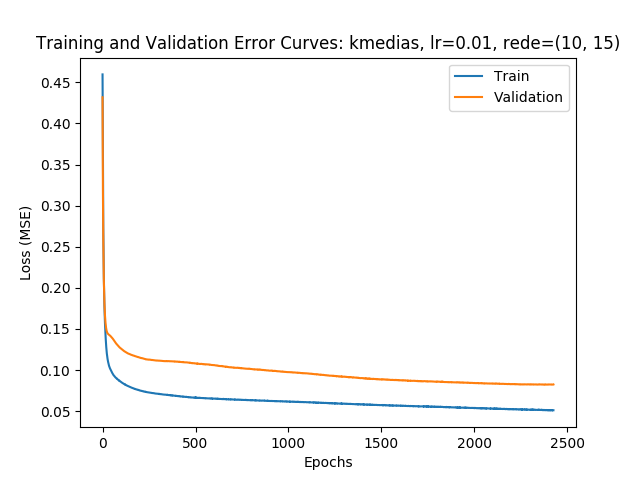

<IPython.core.display.Javascript object>


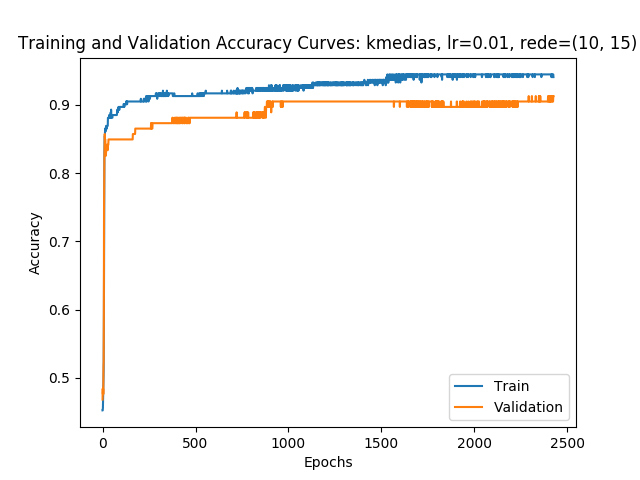

Matriz de confusão
[[1716  182]
 [   8   56]]

Train Loss:       0.0515
Validation Loss:  0.0822
Accuracy:         0.9032
MSE:              0.0968
AUROC:            0.9500


In [35]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=300)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 252 samples, validate on 126 samples
Epoch 1/100000
252/252 [==============================] - 0s - loss: 0.4660 - acc: 0.5000 - val_loss: 0.4621 - val_acc: 0.5000
Epoch 2/100000
252/252 [==============================] - 0s - loss: 0.4414 - acc: 0.5040 - val_loss: 0.4353 - val_acc: 0.5159
Epoch 3/100000
252/252 [==============================] - 0s - loss: 0.3944 - acc: 0.5238 - val_loss: 0.3691 - val_acc: 0.5635
Epoch 4/100000
252/252 [==============================] - 0s - loss: 0.3167 - acc: 0.5794 - val_loss: 0.2945 - val_acc: 0.5873
Epoch 5/100000
252/252 [==============================] - 0s - loss: 0.2469 - acc: 0.6230 - val_loss: 0.2461 - val_acc: 0.5873
Epoch 6/100000
252/252 [==============================] - 0s - loss: 0.2020 - acc: 0.6627 - val_loss: 0.2229 - val_acc: 0.6190
Epoch 7/100000
252/252 [==============================] - 0s - loss: 0.1797 - acc: 0.7183 - val_loss: 0.2113 - val_acc: 0.6349
Epoch 8/100000
252/252 [==============================] - 0s - lo

252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8889 - val_loss: 0.1630 - val_acc: 0.8571
Epoch 128/100000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8889 - val_loss: 0.1619 - val_acc: 0.8571
Epoch 129/100000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8849 - val_loss: 0.1620 - val_acc: 0.8571
Epoch 130/100000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8889 - val_loss: 0.1625 - val_acc: 0.8571
Epoch 131/100000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8889 - val_loss: 0.1625 - val_acc: 0.8571
Epoch 132/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8889 - val_loss: 0.1623 - val_acc: 0.8571
Epoch 133/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8849 - val_loss: 0.1624 - val_acc: 0.8571
Epoch 134/100000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8849 - val_loss: 0.1611 - v

252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.8968 - val_loss: 0.1529 - val_acc: 0.8571
Epoch 254/100000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.8968 - val_loss: 0.1538 - val_acc: 0.8571
Epoch 255/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1534 - val_acc: 0.8571
Epoch 256/100000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1530 - val_acc: 0.8571
Epoch 257/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1525 - val_acc: 0.8571
Epoch 258/100000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1521 - val_acc: 0.8571
Epoch 259/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1520 - val_acc: 0.8571
Epoch 260/100000
252/252 [==============================] - 0s - loss: 0.0864 - acc: 0.9008 - val_loss: 0.1516 - v

252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9087 - val_loss: 0.1419 - val_acc: 0.8571
Epoch 380/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9087 - val_loss: 0.1408 - val_acc: 0.8571
Epoch 381/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9087 - val_loss: 0.1413 - val_acc: 0.8571
Epoch 382/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9087 - val_loss: 0.1409 - val_acc: 0.8571
Epoch 383/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9087 - val_loss: 0.1401 - val_acc: 0.8571
Epoch 384/100000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9087 - val_loss: 0.1404 - val_acc: 0.8571
Epoch 385/100000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9087 - val_loss: 0.1397 - val_acc: 0.8571
Epoch 386/100000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9087 - val_loss: 0.1398 - v

252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1365 - val_acc: 0.8571
Epoch 443/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1357 - val_acc: 0.8571
Epoch 444/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1355 - val_acc: 0.8571
Epoch 445/100000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9087 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 446/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1352 - val_acc: 0.8571
Epoch 447/100000
252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9087 - val_loss: 0.1345 - val_acc: 0.8571
Epoch 448/100000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9087 - val_loss: 0.1346 - val_acc: 0.8571
Epoch 449/100000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9087 - val_loss: 0.1342 - v

252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9127 - val_loss: 0.1288 - val_acc: 0.8571
Epoch 569/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 570/100000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.1278 - val_acc: 0.8571
Epoch 571/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1287 - val_acc: 0.8571
Epoch 572/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 573/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9167 - val_loss: 0.1282 - val_acc: 0.8571
Epoch 574/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 575/100000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9127 - val_loss: 0.1278 - v

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9167 - val_loss: 0.1265 - val_acc: 0.8571
Epoch 632/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.1272 - val_acc: 0.8492
Epoch 633/100000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9167 - val_loss: 0.1266 - val_acc: 0.8571
Epoch 634/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.1270 - val_acc: 0.8571
Epoch 635/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 636/100000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9167 - val_loss: 0.1274 - val_acc: 0.8492
Epoch 637/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9127 - val_loss: 0.1271 - val_acc: 0.8492
Epoch 638/100000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9167 - val_loss: 0.1267 - v

252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9206 - val_loss: 0.1230 - val_acc: 0.8571
Epoch 758/100000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9206 - val_loss: 0.1235 - val_acc: 0.8571
Epoch 759/100000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9206 - val_loss: 0.1227 - val_acc: 0.8571
Epoch 760/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9206 - val_loss: 0.1240 - val_acc: 0.8571
Epoch 761/100000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9206 - val_loss: 0.1232 - val_acc: 0.8571
Epoch 762/100000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9167 - val_loss: 0.1239 - val_acc: 0.8571
Epoch 763/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9206 - val_loss: 0.1227 - val_acc: 0.8571
Epoch 764/100000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9206 - val_loss: 0.1227 - v

252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9206 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 883/100000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9206 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 884/100000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9206 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 885/100000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9206 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 886/100000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9206 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 887/100000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9206 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 888/100000
252/252 [==============================] - 0s - loss: 0.0710 - acc: 0.9206 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 889/100000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9206 - val_loss: 0.1164 - v

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9206 - val_loss: 0.1114 - val_acc: 0.8651
Epoch 1009/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9206 - val_loss: 0.1103 - val_acc: 0.8651
Epoch 1010/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9167 - val_loss: 0.1126 - val_acc: 0.8651
Epoch 1011/100000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9206 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 1012/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9167 - val_loss: 0.1120 - val_acc: 0.8651
Epoch 1013/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9167 - val_loss: 0.1129 - val_acc: 0.8651
Epoch 1014/100000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9206 - val_loss: 0.1114 - val_acc: 0.8651
Epoch 1015/100000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9206 - val_loss: 0.1087 - val_acc: 0.8730
Epoch 1133/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9167 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1134/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1135/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9206 - val_loss: 0.1088 - val_acc: 0.8730
Epoch 1136/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9167 - val_loss: 0.1103 - val_acc: 0.8730
Epoch 1137/100000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9206 - val_loss: 0.1104 - val_acc: 0.8730
Epoch 1138/100000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9167 - val_loss: 0.1101 - val_acc: 0.8730
Epoch 1139/100000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9206 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9167 - val_loss: 0.1090 - val_acc: 0.8730
Epoch 1258/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9167 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 1259/100000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9167 - val_loss: 0.1101 - val_acc: 0.8730
Epoch 1260/100000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9167 - val_loss: 0.1101 - val_acc: 0.8730
Epoch 1261/100000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9167 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 1262/100000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9167 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 1263/100000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9206 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1264/100000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9167 - val_loss: 0.1

252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1090 - val_acc: 0.8730
Epoch 1383/100000
252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9167 - val_loss: 0.1083 - val_acc: 0.8730
Epoch 1384/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1104 - val_acc: 0.8730
Epoch 1385/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1102 - val_acc: 0.8730
Epoch 1386/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1105 - val_acc: 0.8730
Epoch 1387/100000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1388/100000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9167 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1389/100000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9167 - val_loss: 0.1

In [47]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1472/1962 [=====================>........] - ETA: 0s[0.057141038508483878, 0.91997961264016315]


<IPython.core.display.Javascript object>


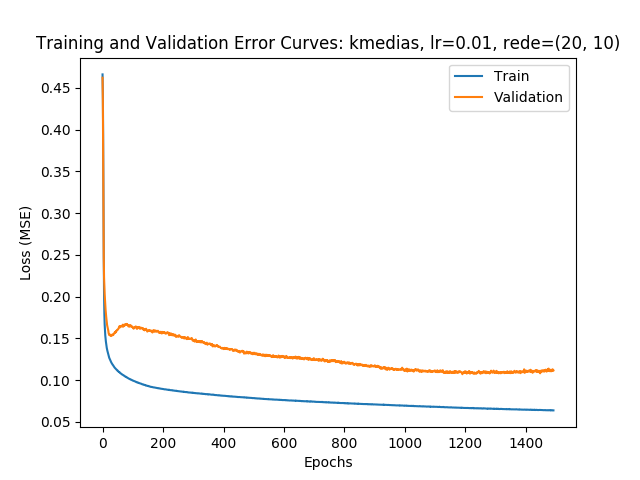

<IPython.core.display.Javascript object>


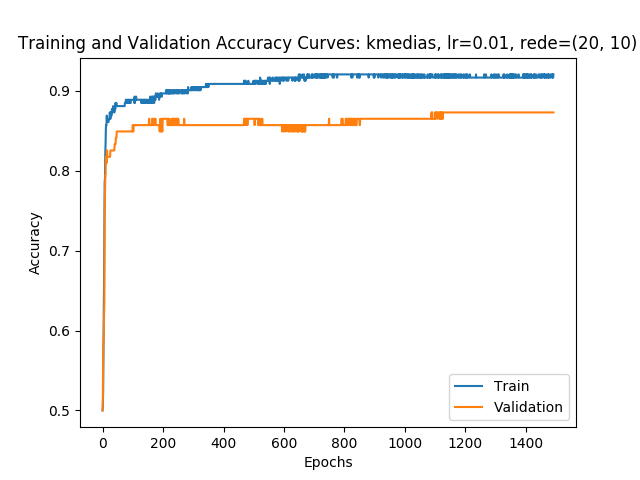

Matriz de confusão
[[1750  148]
 [   8   56]]

Train Loss:       0.0668
Validation Loss:  0.1071
Accuracy:         0.9205
MSE:              0.0795
AUROC:            0.9385


In [26]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [38]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3985 - acc: 0.4921 - val_loss: 0.3333 - val_acc: 0.4841
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2788 - acc: 0.5079 - val_loss: 0.2272 - val_acc: 0.6429
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.1879 - acc: 0.7381 - val_loss: 0.1626 - val_acc: 0.7937
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1530 - acc: 0.7976 - val_loss: 0.1481 - val_acc: 0.8095
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1432 - acc: 0.8095 - val_loss: 0.1431 - val_acc: 0.8254
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1331 - acc: 0.8175 - val_loss: 0.1346 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1228 - acc: 0.8373 - val_loss: 0.1329 - val_acc: 0.8333
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1165 - acc

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1496 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8889
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1604 - val_acc: 0.8889
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8889
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1487 - val_acc: 0.8889
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1531 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8730 - val_loss: 0.1523 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1642 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1539 - val_acc: 0.8810
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1544 - val_acc: 0.8889
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1529 - val_acc: 0.8810
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1583 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1542 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8810 - val_loss: 0.1551 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8810 - val_loss: 0.1644 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1534 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8770 - val_loss: 0.1484 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1582 - val_acc: 0.8810
Epoch 450/2000
252/252 [==============================] - ETA: 0s - loss: 0.0996 - acc: 0.906 - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8889
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1565 - val_acc: 0.8889
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8889
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1537 - val_acc: 0.8810
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.877

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1574 - val_acc: 0.8810
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1521 - val_acc: 0.8810
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8810 - val_loss: 0.1600 - val_acc: 0.8889
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1540 - val_acc: 0.8810
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1588 - val_acc: 0.8810
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1566 - val_acc: 0.8810
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8889
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1583 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1576 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1545 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1553 - val_acc: 0.8730
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1572 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8730 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1575 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1548 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8810 - val_loss: 0.1533 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1621 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1528 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1584 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1560 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1549 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1587 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - ETA: 0s - loss: 0.0784 - acc: 0.937 - 0s - loss: 0.0893 - acc: 0.8810 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1594 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8810 - val_loss: 0.1648 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.881

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8810 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1579 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8810 - val_loss: 0.1568 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8770 - val_loss: 0.1577 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1591 - val_acc: 0.8889
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1547 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1528 - val_acc:

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8889 - val_loss: 0.1601 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1540 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8770 - val_loss: 0.1562 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1567 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1555 - val_acc: 0.8810
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1516 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1630 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1532 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1559 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8810 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1632 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1538 - val_acc:

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1552 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8770 - val_loss: 0.1550 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1530 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8770 - val_loss: 0.1600 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8849 - val_loss: 0.1598 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1518 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8770 - val_loss: 0.1549 - val_acc:

252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8810 - val_loss: 0.1614 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1593 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8770 - val_loss: 0.1586 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8770 - val_loss: 0.1596 - val_acc: 0.8889
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1563 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8810 - val_loss: 0.1558 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8810 - val_loss: 0.1592 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1587 - val_acc:

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1618 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8770 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8849 - val_loss: 0.1528 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1573 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1557 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8730 - val_loss: 0.1557 - val_acc: 0.8730
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8849 - val_loss: 0.1638 - val_acc: 0.8889
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1561 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1597 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1575 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1580 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8849 - val_loss: 0.1526 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8810 - val_loss: 0.1538 - val_acc: 0.8810
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8849 - val_loss: 0.1612 - val_acc:

252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1572 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8810 - val_loss: 0.1569 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.1589 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1585 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0895 - acc: 0.8849 - val_loss: 0.1586 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1536 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8849 - val_loss: 0.1593 - val_acc:

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.079650119691327681, 0.91335372075392929]


<IPython.core.display.Javascript object>


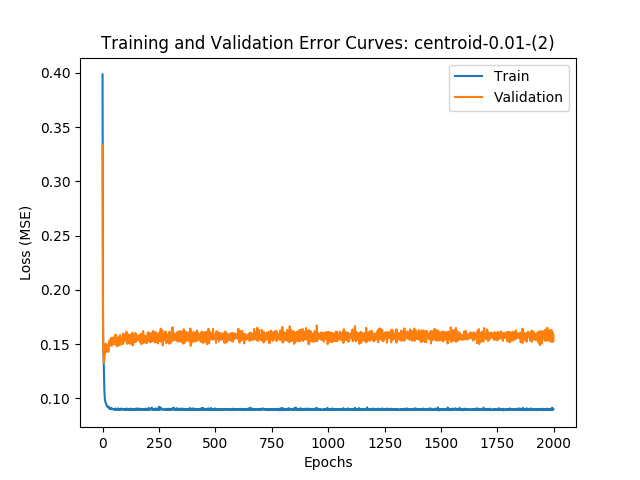

<IPython.core.display.Javascript object>


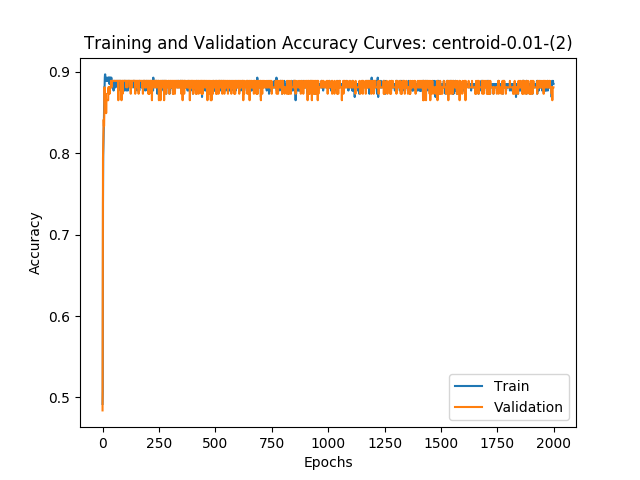

Matriz de confusão
[[1736  162]
 [   7   57]]

Train Loss:       0.1228
Validation Loss:  0.1329
Accuracy:         0.9139
MSE:              0.0861
AUROC:            0.9450


In [40]:
plot_training_error_curves(history, "centroid-0.01-(2)")
plot_training_acc_curves(history, "centroid-0.01-(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [41]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4484 - acc: 0.4683 - val_loss: 0.3372 - val_acc: 0.5635
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2772 - acc: 0.6389 - val_loss: 0.2569 - val_acc: 0.6984
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2030 - acc: 0.7381 - val_loss: 0.1945 - val_acc: 0.7619
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1571 - acc: 0.7937 - val_loss: 0.1539 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1342 - acc: 0.8294 - val_loss: 0.1293 - val_acc: 0.8413
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8651 - val_loss: 0.1287 - val_acc: 0.8571
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1409 - val_acc: 0.8571
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1039 - acc

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9087 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9127
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.9127
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9127 - val_loss: 0.0786 - val_acc: 0.9206
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0798 - val_acc: 0.9127
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.0782 - val_acc: 0.9206
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9087 - val_loss: 0.0823 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9206
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0865 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0755 - val_acc: 0.9206
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9127
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9048 - val_loss: 0.0746 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0853 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.0743 - val_acc: 0.9206
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0738 - val_acc: 0.9206
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9127 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0765 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.9008 - val_loss: 0.0754 - val_acc: 0.9127
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9127 - val_loss: 0.0844 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0754 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.0737 - val_acc: 0.9206
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.0852 - val_acc: 0.8889
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9127 - val_loss: 0.0747 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0795 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0752 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0818 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.0745 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0742 - val_acc: 0.9048
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0730 - val_acc: 0.9286
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9048 - val_loss: 0.0858 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9087 - val_loss: 0.0752 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0772 - val_acc: 0.9127
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0739 - val_acc: 0.9206
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0782 - val_acc: 0.8968
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0763 - val_acc: 0.9127
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0750 - val_acc: 0.9048
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9167 - val_loss: 0.0749 - val_acc: 0.9127
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0924 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9127
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0773 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9087 - val_loss: 0.0788 - val_acc: 0.9127
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0803 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0743 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0790 - val_acc: 0.8968
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.0731 - val_acc: 0.9206
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0778 - val_acc: 0.8968
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9087 - val_loss: 0.0734 - val_acc: 0.9206
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9087 - val_loss: 0.0753 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9087 - val_loss: 0.0744 - val_acc:

252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0740 - val_acc: 0.9127
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9167 - val_loss: 0.0762 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0742 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.0781 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9087 - val_loss: 0.0763 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9167 - val_loss: 0.0771 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.0753 - val_acc:

252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9087 - val_loss: 0.0733 - val_acc: 0.9206
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9127 - val_loss: 0.0774 - val_acc: 0.9048
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.9127 - val_loss: 0.0767 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9087 - val_loss: 0.0749 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9127 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.0835 - val_acc:

252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9127 - val_loss: 0.0753 - val_acc: 0.9206
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0760 - val_acc: 0.9048
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.0735 - val_acc: 0.9127
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9127 - val_loss: 0.0762 - val_acc: 0.9127
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9127 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9127 - val_loss: 0.0876 - val_acc:

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9087 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0737 - val_acc: 0.9127
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0771 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9048 - val_loss: 0.0748 - val_acc: 0.9127
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0779 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0751 - val_acc: 0.9127
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.0741 - val_acc: 0.9127
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9087 - val_loss: 0.0760 - val_acc:

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0740 - val_acc: 0.9206
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9167 - val_loss: 0.0884 - val_acc: 0.8968
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.0732 - val_acc: 0.9206
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0777 - val_acc: 0.9048
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9127
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9127 - val_loss: 0.0819 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0764 - val_acc: 0.9048
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9127 - val_loss: 0.0731 - val_acc:

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9167 - val_loss: 0.0744 - val_acc: 0.9206
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.0755 - val_acc: 0.9048
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9127 - val_loss: 0.0770 - val_acc: 0.9048
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0758 - val_acc: 0.9206
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.0759 - val_acc: 0.9048
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9087 - val_loss: 0.0729 - val_acc: 0.9206
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0775 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.0737 - val_acc:

In [42]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.096324953433813545, 0.89500509677920015]


<IPython.core.display.Javascript object>


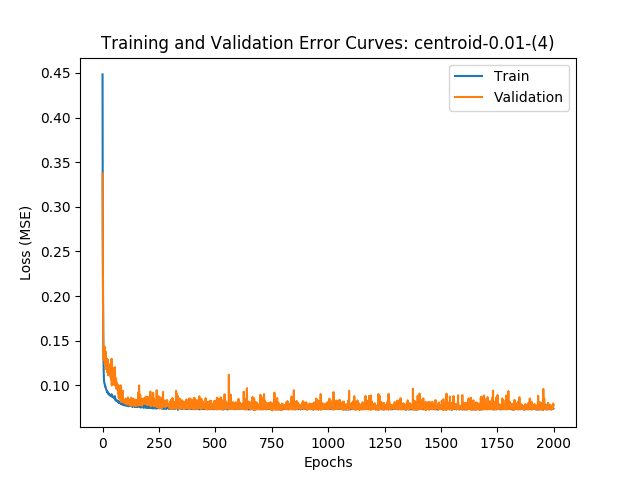

<IPython.core.display.Javascript object>


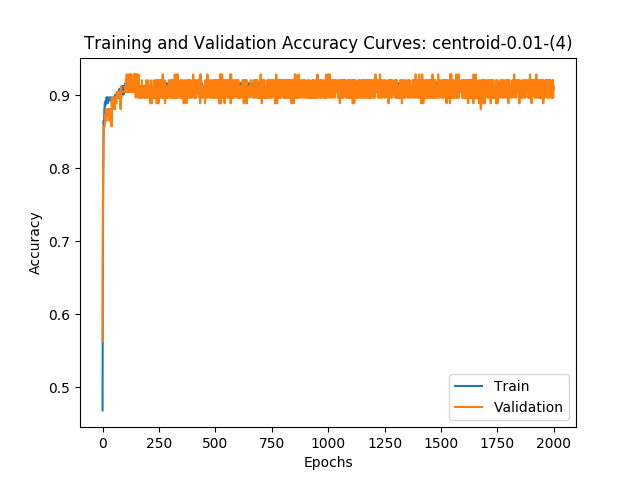

Matriz de confusão
[[1700  198]
 [   8   56]]

Train Loss:       0.0745
Validation Loss:  0.0719
Accuracy:         0.8950
MSE:              0.1050
AUROC:            0.9276


In [43]:
plot_training_error_curves(history, "centroid-0.01-(4)")
plot_training_acc_curves(history, "centroid-0.01-(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))